# stSME Clustering

**stSME** is a novel normalisation method implemented in *stLearn* software.   
It's designed for **s**patial **t**ranscriptomics data and utilised tissue **S**patial location, **M**orphology, , and gene **E**xpression.

This tutorial demonstrates how to use *stLearn* to perform **stSME** clustering for spatial transcriptomics data

In this tutorial we first focus on **Mouse Brain (Coronal)** Visium dataset from [10x genomics website](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Adult_Mouse_Brain).

## Mouse Brain (Coronal)

### 1. Preparation

In [1]:
import scanpy as sc
import stlearn as st
import pathlib as pathlib
import numpy as np
import random as random
import os as os

st.settings.set_figure_params(dpi=120)

# Make sure all the seeds are set
seed = 0
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this 

In [2]:
st.settings.datasetdir =  pathlib.Path.cwd().parent / "data"

In [3]:
mouse_brain_coronal = sc.datasets.visium_sge(sample_id="V1_Adult_Mouse_Brain")
mouse_brain_coronal = st.convert_scanpy(mouse_brain_coronal)

In [4]:
# pre-processing for gene count table
st.pp.filter_genes(mouse_brain_coronal, min_cells=1)
st.pp.normalize_total(mouse_brain_coronal)
st.pp.log1p(mouse_brain_coronal)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
# pre-processing for spot image
st.pp.tiling(mouse_brain_coronal, out_path="tiling")

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(mouse_brain_coronal)

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|█████████▉ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


### 2. run stSME clustering

In [6]:
# run PCA for gene expression data
st.em.run_pca(mouse_brain_coronal, n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [7]:
mouse_brain_coronal_sme = mouse_brain_coronal.copy()
# apply stSME to normalise log transformed data
st.spatial.SME.SME_normalize(mouse_brain_coronal_sme, use_data="raw")
mouse_brain_coronal_sme.X = mouse_brain_coronal_sme.obsm['raw_SME_normalized']
st.pp.scale(mouse_brain_coronal_sme)
st.em.run_pca(mouse_brain_coronal_sme, n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans cluster ...
Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


AnnData object with n_obs × n_vars = 2702 × 21949
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors'
    obsm: 'spatial', 'X_tile_feature', 'X_morphology', 'X_pca', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'

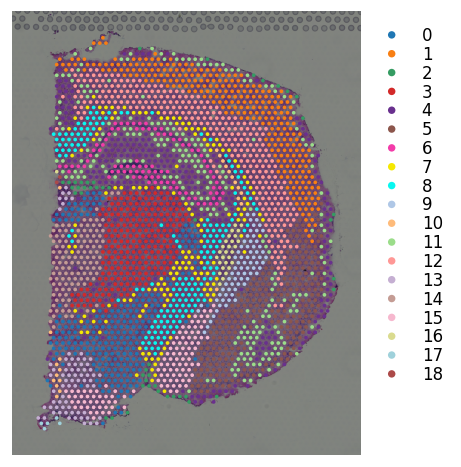

In [8]:
# K-means clustering on stSME normalised PCA
st.tl.clustering.kmeans(mouse_brain_coronal_sme, n_clusters=19, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(mouse_brain_coronal_sme, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


AnnData object with n_obs × n_vars = 2702 × 21949
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'X_pca_kmeans', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'spatial', 'X_tile_feature', 'X_morphology', 'X_pca', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

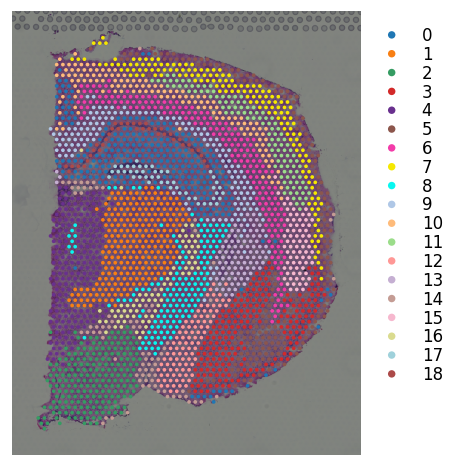

In [9]:
# louvain clustering on stSME normalised data
st.pp.neighbors(mouse_brain_coronal_sme, n_neighbors=17, use_rep='X_pca')
st.tl.clustering.louvain(mouse_brain_coronal_sme, resolution=1.19)
st.pl.cluster_plot(mouse_brain_coronal_sme, use_label="louvain")

we now move to Mouse Brain (Sagittal Posterior) Visium dataset from [10x genomics website](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Mouse_Brain_Sagittal_Posterior).

## Mouse Brain (Sagittal Posterior)

### 1. Preparation

In [10]:
mouse_brain_sagittal = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Posterior")
mouse_brain_sagittal = st.convert_scanpy(mouse_brain_sagittal)

In [11]:
# pre-processing for gene count table
st.pp.filter_genes(mouse_brain_sagittal, min_cells=1)
st.pp.normalize_total(mouse_brain_sagittal)
st.pp.log1p(mouse_brain_sagittal)
st.pp.scale(mouse_brain_sagittal)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


In [12]:
# pre-processing for spot image
st.pp.tiling(mouse_brain_sagittal, out_path="tiling")

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(mouse_brain_sagittal)

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature:  98%|█████████▊ [ time left: 00:03 ]

The morphology feature is added to adata.obsm['X_morphology']!


### 2. run stSME clustering

In [13]:
# run PCA for gene expression data
st.em.run_pca(mouse_brain_sagittal, n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [14]:
mouse_brain_sagittal_sme = mouse_brain_sagittal.copy()
# apply stSME to normalise log transformed data
# with weights from morphological Similarly and physcial distance
st.spatial.SME.SME_normalize(mouse_brain_sagittal_sme, use_data="raw",
                             weights="weights_matrix_pd_md")
mouse_brain_sagittal_sme.X = mouse_brain_sagittal_sme.obsm['raw_SME_normalized']
st.pp.scale(mouse_brain_sagittal_sme)
st.em.run_pca(mouse_brain_sagittal_sme, n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans cluster ...
Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


AnnData object with n_obs × n_vars = 3355 × 21363
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors'
    obsm: 'spatial', 'X_tile_feature', 'X_morphology', 'X_pca', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'

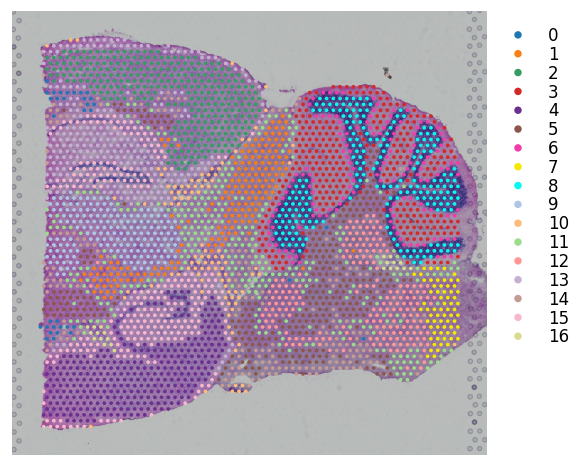

In [15]:
# K-means clustering on stSME normalised PCA
st.tl.clustering.kmeans(mouse_brain_sagittal_sme, n_clusters=17, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(mouse_brain_sagittal_sme, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


AnnData object with n_obs × n_vars = 3355 × 21363
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'X_pca_kmeans', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'spatial', 'X_tile_feature', 'X_morphology', 'X_pca', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

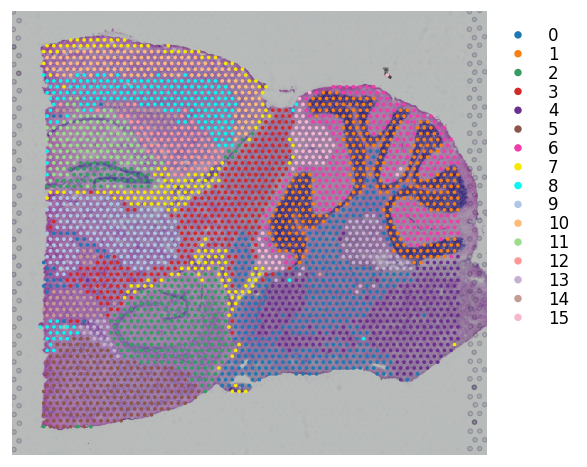

In [16]:
# louvain clustering on stSME normalised data
st.pp.neighbors(mouse_brain_sagittal_sme, n_neighbors=20, use_rep='X_pca')
st.tl.clustering.louvain(mouse_brain_sagittal_sme)
st.pl.cluster_plot(mouse_brain_sagittal_sme, use_label="louvain")

<b>Tutorial by Xiao Tan</b>